<a href="https://colab.research.google.com/github/nikhilbansal23/TelcoRetentionStratergies/blob/main/Telco_Retention_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import uuid
from datetime import datetime
from scipy.stats import norm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import plotly.figure_factory as ff
import json

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# **Data Manipulation**

In [4]:
path = '/content/drive/MyDrive/Datasets/Telco Retention Strategies/Telco-Customer-Churn.json'

In [5]:
df = pd.read_json(path)

In [6]:
df.head(1)

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."


In [7]:
df.columns

Index(['customerID', 'Churn', 'customer', 'phone', 'internet', 'account'], dtype='object')

In [8]:
df.internet[0]

{'InternetService': 'DSL',
 'OnlineSecurity': 'No',
 'OnlineBackup': 'Yes',
 'DeviceProtection': 'No',
 'TechSupport': 'Yes',
 'StreamingTV': 'Yes',
 'StreamingMovies': 'No'}

In [9]:
# Normalize the 'customer_info' column
normalized_cust = pd.json_normalize(df['customer'])
normalized_phone = pd.json_normalize(df['phone'])
normalized_account = pd.json_normalize(df['account'])
normalized_internet = pd.json_normalize(df['internet'])


In [10]:
# Concatenate the normalized data with the original DataFrame
df = pd.concat([df, normalized_cust,normalized_phone,normalized_account,normalized_internet], axis=1)

# Drop the original 'customer_info' column
df = df.drop(['customer','phone','account','internet'], axis=1)

In [11]:
df.head(1)

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,One year,Yes,Mailed check,65.6,593.3,DSL,No,Yes,No,Yes,Yes,No


In [12]:
df.columns

Index(['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly', 'Charges.Total',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [13]:
print("Telco data count "+str(len(df)))

Telco data count 7267


In [14]:
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [15]:
# Remove rows with NaN values in the 'Churn' column
df.dropna(subset=['Churn','Charges.Total'], inplace=True)

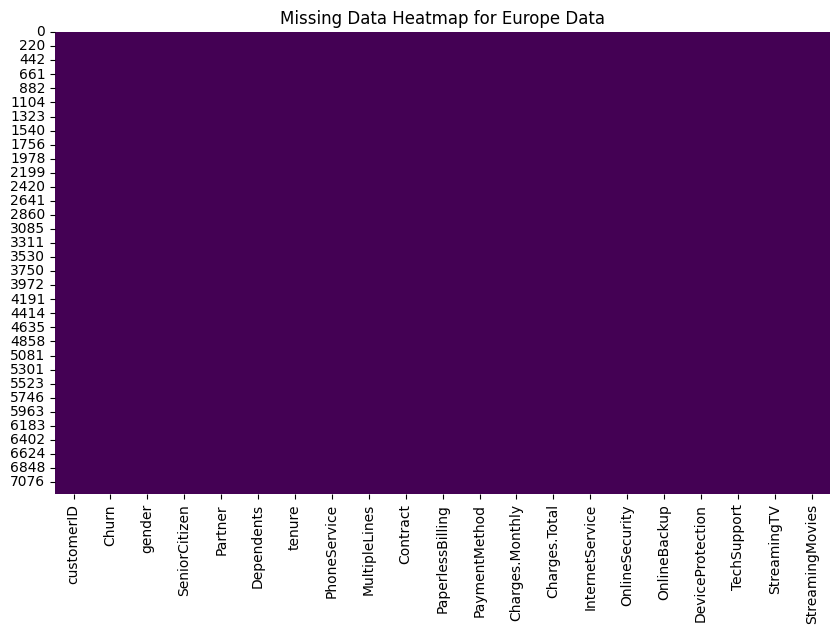

In [16]:
missing_data = df.isnull().sum()

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap for Europe Data')
plt.show()

In [17]:
df.rename(columns={'Charges.Monthly': 'Charges_Monthly','Charges.Total':'Charges_Total'}, inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Churn             7032 non-null   object 
 2   gender            7032 non-null   object 
 3   SeniorCitizen     7032 non-null   int64  
 4   Partner           7032 non-null   object 
 5   Dependents        7032 non-null   object 
 6   tenure            7032 non-null   int64  
 7   PhoneService      7032 non-null   object 
 8   MultipleLines     7032 non-null   object 
 9   Contract          7032 non-null   object 
 10  PaperlessBilling  7032 non-null   object 
 11  PaymentMethod     7032 non-null   object 
 12  Charges_Monthly   7032 non-null   float64
 13  Charges_Total     7032 non-null   object 
 14  InternetService   7032 non-null   object 
 15  OnlineSecurity    7032 non-null   object 
 16  OnlineBackup      7032 non-null   object 


# **Exploratory Data Analysis**

In [19]:
# Count the occurrences of each unique value in the 'Churn' column
churn_counts = df['Churn'].value_counts().reset_index()
churn_counts.columns = ['Churn', 'Count']

# Create a bar chart using Plotly Express
fig = px.bar(churn_counts, x='Churn', y='Count', color='Churn',
             labels={'Churn': 'Churn Status', 'Count': 'Count'},
             title='Churn Counts')

# Show the plot
fig.show()

In [20]:
# Filter the data for churned customers
churned_data = df[df['Churn'] == 'Yes']

# Calculate gender-wise count of churned customers
gender_churn_count = churned_data['gender'].value_counts().reset_index()

# Plotting gender-wise count of churned customers using Plotly
fig = px.bar(gender_churn_count, x='index', y='gender', color='index')
fig.update_layout(
    title='Gender-wise Count of Churned Customers',
    xaxis_title='Gender',
    yaxis_title='Count',
    xaxis={'categoryorder':'total descending'}  # Order by total count
)
fig.show()

In [21]:
# Create a line chart using Plotly Express
churned_data = df[df['Churn'] == 'Yes']
fig = px.scatter(churned_data, x='tenure', y='Charges_Monthly', color='gender',
              labels={'tenure': 'Tenure', 'Charges_Monthly': 'Monthly Charges', 'gender': 'Gender'},
              title='Monthly Charges Over Tenure by Gender')

# Show the plot
fig.show()

In [22]:
# Create a box plot using Plotly Express
fig = px.box(df, x='Churn', y='tenure',
             labels={'Churn': 'Churn Status', 'tenure': 'Tenure'},
             title='Tenure Distribution by Churn')

# Show the plot
fig.show()


In [23]:
# Create a box plot using Plotly Express
fig = px.box(df, x='Churn', y='Charges_Monthly',
             labels={'Churn': 'Churn Status', 'Charges_Monthly': 'Monthly Charges'},
             title='Monthly Charges by Churn Status')

# Show the plot
fig.show()

In [24]:
df.columns

Index(['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Charges_Monthly', 'Charges_Total',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [25]:
churned_data = df[df['Churn'] == 'Yes']

fig = px.histogram(churned_data, x='Charges_Monthly',
                   labels={'Charges_Monthly': 'Monthly Charges', 'count': 'Count'},
                   title='Distribution of Monthly Charges')

# Show the plot
fig.show()


In [26]:
# Create a scatter plot for TotalCharges
churned_data = churned_data[df['Churn'] == 'Yes']
fig = px.scatter(df, x='Charges_Total', y=df.index,
                 labels={'Charges_Total': 'Total Charges', 'y': 'Index'},
                 title='Scatter Plot of Total Charges for Churned Customers')

# Show the plot
fig.show()

<ipython-input-26-02ac7009409c>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [27]:
# Filter the data for churned customers
churned_data = df[df['Churn'] == 'Yes']

# Calculate churned customer count for each tenure
tenure_counts = churned_data['tenure'].value_counts().sort_index().reset_index()
tenure_counts.columns = ['Tenure', 'Count']

# Plotting churned customer volume against tenure using Plotly
fig = px.bar(tenure_counts, x='Tenure', y='Count', color='Count')
fig.update_layout(
    title='Churned Customer Volume by Tenure',
    xaxis_title='Tenure (Months)',
    yaxis_title='Number of Churned Customers',
    xaxis={'categoryorder':'total ascending'}  # Order by tenure
)
fig.show()

In [28]:
cat_columns = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'Contract', 'PaperlessBilling',
               'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
               'StreamingTV', 'StreamingMovies']

# Filter the data for churned customers
churned_data = df[df['Churn'] == 'Yes']

# Plotting multiple bar charts for each categorical column
for col in cat_columns:
    counts = churned_data[col].value_counts().reset_index()
    counts.columns = [col, 'Count']

    fig = px.bar(counts, x=col, y='Count', color='Count', title=f'Distribution of {col}')
    fig.update_layout(
        height=500,
        width=700,
        xaxis_title=col,
        yaxis_title='Count'
    )
    fig.show()

In [29]:
df.columns

Index(['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Charges_Monthly', 'Charges_Total',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

## **Feature Selection**

In [30]:
import pandas as pd
import scipy.stats as stats

# Assuming 'df' is your DataFrame and 'Churn' is the target column

significant_features = []

for col in df.columns:
    if col != 'Churn':  # Exclude the target variable
        if df[col].dtype == 'object':  # Categorical variables
            cross_tab = pd.crosstab(df[col], df['Churn'])
            chi2, p_value, _, _ = stats.chi2_contingency(cross_tab)
        else:  # Numerical variables
            churn_yes = df[df['Churn'] == 'Yes'][col]
            churn_no = df[df['Churn'] == 'No'][col]
            _, p_value = stats.ttest_ind(churn_yes, churn_no)

        # Checking if p-value is less than 0.05
        if p_value < 0.05:
            significant_features.append(col)

print("Significant features based on p-value:", significant_features)


Significant features based on p-value: ['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MultipleLines', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges_Monthly', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']


## Handling Categorical Features using Get Dummies

In [31]:
cat_lt = ['OnlineBackup','Dependents','gender','SeniorCitizen','Partner','PhoneService','MultipleLines','Contract','PaperlessBilling','PaymentMethod','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
dummies = pd.get_dummies(df[cat_lt])
dummies = dummies.astype(int)


In [32]:
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

In [33]:
df = pd.concat([df, dummies], axis=1)
df.drop(columns= cat_lt, inplace=True)

In [34]:
df.columns

Index(['customerID', 'Churn', 'tenure', 'Charges_Monthly', 'Charges_Total',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'Dependents_No', 'Dependents_Yes', 'gender_Female',
       'gender_Male', 'Partner_No', 'Partner_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceP

In [35]:
df.drop(columns= 'customerID', inplace=True)

## Handling Numerical Features by Binning

In [36]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Convert columns to numeric types (handling non-numeric or missing values)
df['MonthlyCharges'] = pd.to_numeric(df['Charges_Monthly'], errors='coerce')
df['TotalCharges'] = pd.to_numeric(df['Charges_Total'], errors='coerce')

# Define the bin edges
bin_edges = [0, 100, 1000, float('inf')]  # Adjust these bin edges according to your requirements

# Define bin labels
bin_labels = ['0-100', '100-1000', '1000+']

# Bin 'MonthlyCharges' and 'TotalCharges'
df['MonthlyCharges_bin'] = pd.cut(df['MonthlyCharges'], bins=bin_edges, labels=bin_labels)
df['TotalCharges_bin'] = pd.cut(df['TotalCharges'], bins=bin_edges, labels=bin_labels)

# Convert bins to separate columns
monthly_charges_dummies = pd.get_dummies(df['MonthlyCharges_bin'], prefix='MonthlyCharges')
total_charges_dummies = pd.get_dummies(df['TotalCharges_bin'], prefix='TotalCharges')

# Concatenate the dummy columns to the original DataFrame
df = pd.concat([df, monthly_charges_dummies, total_charges_dummies], axis=1)



In [37]:

bin_edges = [0, 12, 24, 36, 48, 60, 72, float('inf')]
bin_labels = ['0-12', '13-24', '25-36', '37-48', '49-60', '61-72', '72+']

# Bin 'tenure'
df['Tenure_bin'] = pd.cut(df['tenure'], bins=bin_edges, labels=bin_labels)

# Convert bins to separate columns
tenure_dummies = pd.get_dummies(df['Tenure_bin'], prefix='Tenure')

# Concatenate the dummy columns to the original DataFrame
df = pd.concat([df, tenure_dummies], axis=1)

# Drop the original bin column if needed
# df.drop('Tenure_bin', axis=1, inplace=True)


In [38]:
df.drop(['Charges_Monthly','Charges_Total','MonthlyCharges','TotalCharges','MonthlyCharges_bin','TotalCharges_bin','Tenure_bin','tenure'], axis=1, inplace=True)


In [39]:
len(df.columns)

58

## **Handling Corelation**

In [40]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Calculating the correlation matrix
correlation_matrix = df.corr().abs()

# Finding highly correlated pairs
highly_correlated_pairs = {}
threshold = 0.7

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i] + ' - ' + correlation_matrix.columns[j]
            highly_correlated_pairs[colname] = correlation_matrix.iloc[i, j]

# Remove one feature from each highly correlated pair
features_to_remove = set()
for pair in highly_correlated_pairs:
    feature1, feature2 = pair.split(' - ')
    if feature1 not in features_to_remove:
        features_to_remove.add(feature2)

# Drop the identified features
df_filtered = df.drop(columns=features_to_remove)


In [41]:

correlation_matrix_filtered = df_filtered.corr().abs()

# Finding highly correlated pairs in the filtered correlation matrix
highly_correlated_pairs_filtered = {}
threshold = 0.7

for i in range(len(correlation_matrix_filtered.columns)):
    for j in range(i):
        if abs(correlation_matrix_filtered.iloc[i, j]) > threshold:
            colname = correlation_matrix_filtered.columns[i] + ' - ' + correlation_matrix_filtered.columns[j]
            highly_correlated_pairs_filtered[colname] = correlation_matrix_filtered.iloc[i, j]

# Displaying any remaining highly correlated pairs and their correlation values
if len(highly_correlated_pairs_filtered) == 0:
    print("No highly correlated pairs found after removal.")
else:
    for pair, corr_value in highly_correlated_pairs_filtered.items():
        print(f"{pair}: {corr_value}")


No highly correlated pairs found after removal.


In [42]:
len(df_filtered.columns)

37

# Model Building

In [43]:
from sklearn.model_selection import train_test_split


In [44]:
X = df_filtered.drop('Churn', axis=1)  # Features
y = df_filtered['Churn']  # Target variable

## Oversampling using SMOTE

In [45]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to generate synthetic samples for minority class
X_resampled, y_resampled = smote.fit_resample(X, y)


In [62]:
y_resampled.value_counts()

0    5163
1    5163
Name: Churn, dtype: int64

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=50)

In [48]:
y_train.value_counts()

0    3102
1    3093
Name: Churn, dtype: int64

# **Logistic Regression**

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)  # You can adjust parameters as needed

# Train the model
logreg.fit(X_train, y_train)


# Predict on validation set
lg_predictions = logreg.predict(X_test)

# Evaluate model performance
lg_accuracy = accuracy_score(y_test, lg_predictions)

# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, lg_predictions))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, lg_predictions)

# Create an array to label confusion matrix
class_names = ['Not Churn', 'Churn']  # Replace with your class names if needed

# Create a heatmap for the confusion matrix using Plotly
fig = ff.create_annotated_heatmap(
    z=cm,
    x=class_names,
    y=class_names,
    colorscale='Blues',
    showscale=True
)

# Add title and labels
fig.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label')
)

fig.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      2061
           1       0.81      0.84      0.83      2070

    accuracy                           0.82      4131
   macro avg       0.82      0.82      0.82      4131
weighted avg       0.82      0.82      0.82      4131

Confusion Matrix:


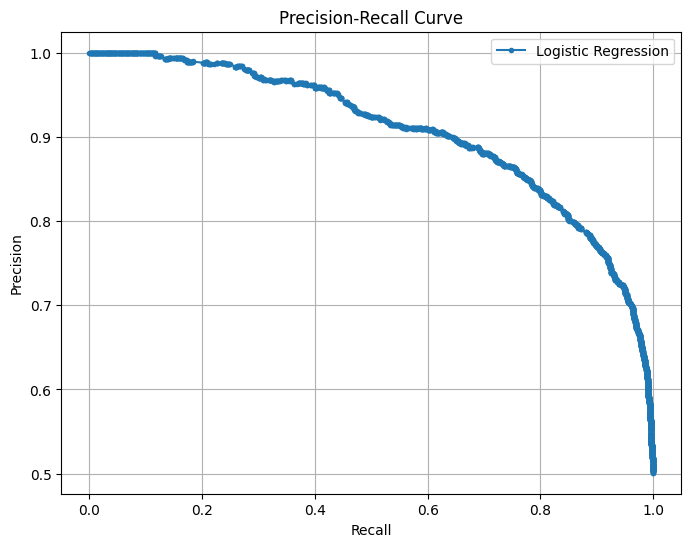

In [50]:
# Predict probabilities of positive class for test set
from sklearn.metrics import precision_recall_curve
y_probs = logreg.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

Top 10 Relevant Features for Logistic Regression:
                                   Feature  Coefficient  Abs_Coefficient
0      StreamingMovies_No internet service    -8.532128         8.532128
1    PaymentMethod_Credit card (automatic)    -3.517435         3.517435
2                             Tenure_61-72    -3.491354         3.491354
3  PaymentMethod_Bank transfer (automatic)    -3.325474         3.325474
4               PaymentMethod_Mailed check    -3.287350         3.287350
5                        Contract_Two year    -3.121736         3.121736
6                             Tenure_37-48    -3.075964         3.075964
7                             Tenure_25-36    -3.020085         3.020085
8                             Tenure_49-60    -3.000331         3.000331
9           PaymentMethod_Electronic check    -2.768141         2.768141


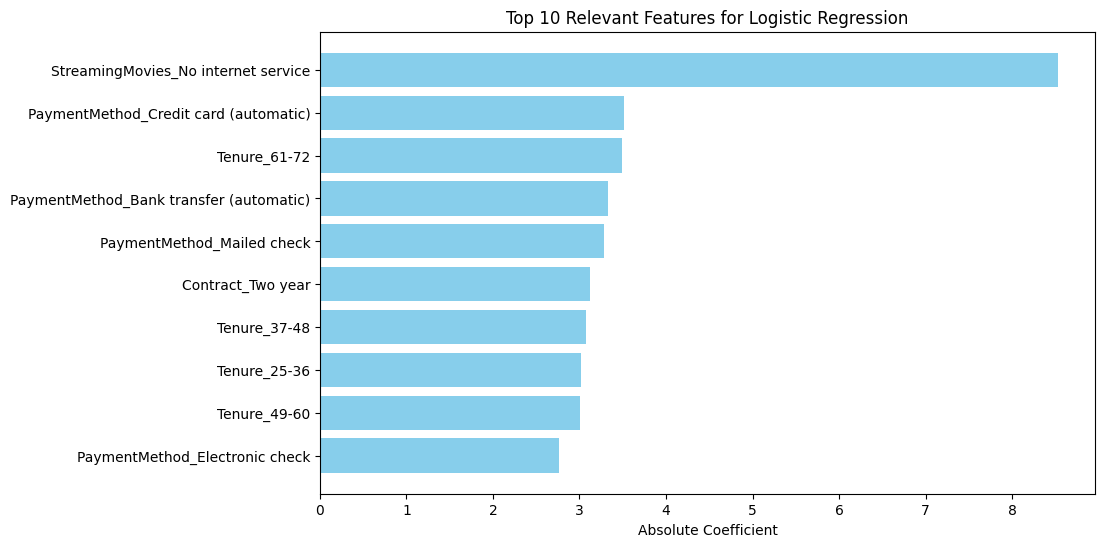

In [51]:
# Get feature coefficients from the model
feature_coefficients = logreg.coef_[0]

# Create a DataFrame with feature names and their coefficients
feature_coefficient_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': feature_coefficients})

# Sort features by absolute coefficient values
feature_coefficient_df['Abs_Coefficient'] = feature_coefficient_df['Coefficient'].abs()
feature_coefficient_df = feature_coefficient_df.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)

# Display and plot the top N relevant features
top_n = 10  # Set the number of top features to display and plot

print(f"Top {top_n} Relevant Features for Logistic Regression:")
print(feature_coefficient_df.head(top_n))

# Plotting the top N relevant features
plt.figure(figsize=(10, 6))
plt.barh(feature_coefficient_df['Feature'][:top_n], feature_coefficient_df['Abs_Coefficient'][:top_n], color='skyblue')
plt.xlabel('Absolute Coefficient')
plt.title(f'Top {top_n} Relevant Features for Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

# **XG Boost Classifier**

In [52]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create and train the XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
xgb_pred = xgb_model.predict(X_test)


# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, xgb_pred))

print("Confusion Matrix:")
# print(confusion_matrix(y_test, xgb_pred))
cm = confusion_matrix(y_test, xgb_pred)
# Create an array to label confusion matrix
class_names = ['Not Churn', 'Churn']  # Replace with your class names if needed

# Create a heatmap for the confusion matrix using Plotly
fig = ff.create_annotated_heatmap(
    z=cm,
    x=class_names,
    y=class_names,
    colorscale='Blues',
    showscale=True
)

# Add title and labels
fig.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label')
)

fig.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      2061
           1       0.82      0.85      0.83      2070

    accuracy                           0.83      4131
   macro avg       0.83      0.83      0.83      4131
weighted avg       0.83      0.83      0.83      4131

Confusion Matrix:


# **Random Forrest**

In [53]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create SelectFromModel and define parameters for feature selection
feature_selection = SelectFromModel(RandomForestClassifier(random_state=42))

# Define the parameter grid for GridSearchCV
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [None, 5, 10, 15],
    # Add other hyperparameters to tune
    'threshold': ['median', 'mean']  # Threshold for feature selection
}




In [54]:
# Create the GridSearchCV object with feature selection
grid_search = GridSearchCV(estimator=feature_selection, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'SelectFromModel' object has no attribute 'predict'


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning:

Scoring 

GridSearchCV(cv=5,
             estimator=SelectFromModel(estimator=RandomForestClassifier(random_state=42)),
             param_grid={'estimator__max_depth': [None, 5, 10, 15],
                         'estimator__n_estimators': [100, 200, 300],
                         'threshold': ['median', 'mean']},
             scoring='accuracy')

In [55]:
# Get the best estimator from GridSearchCV
best_feature_selection = grid_search.best_estimator_

# Transform features using the best feature selection method
selected_features = best_feature_selection.transform(X_train)
X_test_selected = best_feature_selection.transform(X_test)

# Train a Random Forest Classifier using selected features
rf_classifier.fit(selected_features, y_train)

# Predict on the test set using the model trained with selected features
y_pred = rf_classifier.predict(X_test_selected)

In [56]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      2061
           1       0.78      0.84      0.81      2070

    accuracy                           0.80      4131
   macro avg       0.80      0.80      0.80      4131
weighted avg       0.80      0.80      0.80      4131

Confusion Matrix:
[[1565  496]
 [ 336 1734]]


In [57]:
import plotly.figure_factory as ff
import numpy as np

# Assuming 'conf_matrix' is the confusion matrix obtained from the RandomForestClassifier

# Define class labels
class_labels = ['Not Churned', 'Churned']  # Replace with your class labels

# Create the confusion matrix heatmap
fig = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=class_labels,
    y=class_labels[::-1],
    colorscale='Viridis',
    showscale=True
)

# Update the layout for better visualization
fig.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted',
    yaxis_title='Actual',
    yaxis=dict(autorange='reversed')
)

# Show the plot
fig.show()


In [58]:
# Assuming 'X' is your feature matrix
num_features = X_test_selected.shape[1]
print("Number of features in the dataset:", num_features)

Number of features in the dataset: 18


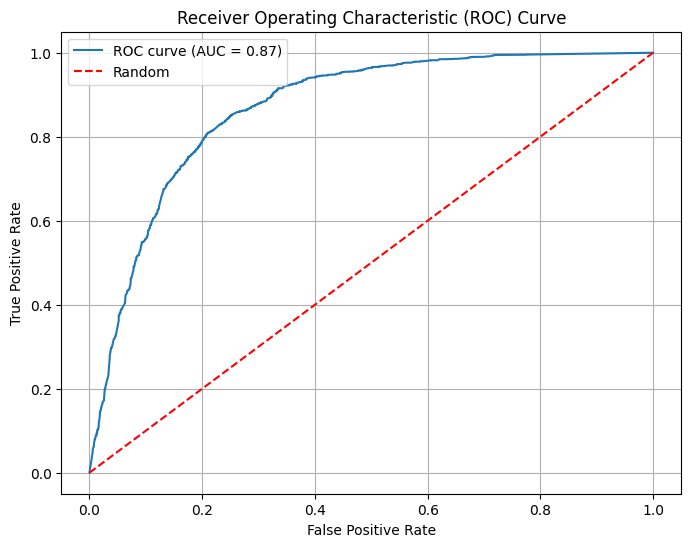

In [59]:
from sklearn.metrics import roc_curve, roc_auc_score
# Predict probabilities of positive class for test set
y_probs = rf_classifier.predict_proba(X_test_selected)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create Balanced Random Forest classifier
brf_classifier = BalancedRandomForestClassifier(random_state=42)

# Train the model
brf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = brf_classifier.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning:

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning:

`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning:

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning:

`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate

Accuracy: 0.8327281529895909
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      2061
           1       0.82      0.86      0.84      2070

    accuracy                           0.83      4131
   macro avg       0.83      0.83      0.83      4131
weighted avg       0.83      0.83      0.83      4131

Confusion Matrix:
[[1668  393]
 [ 298 1772]]


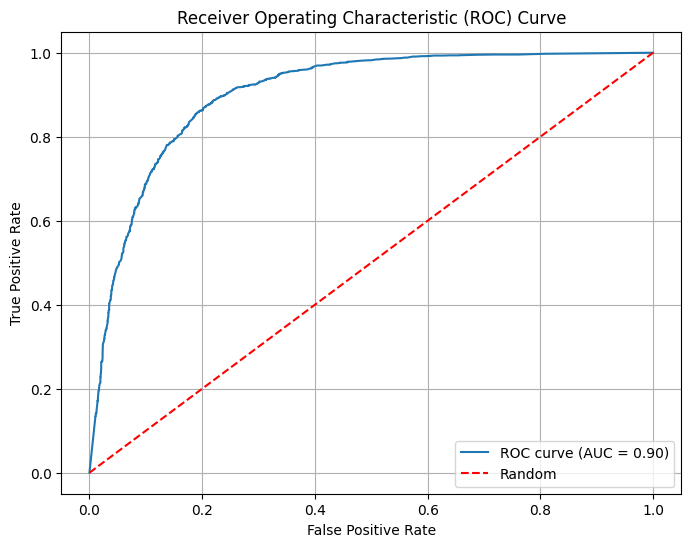

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score
# Predict probabilities of positive class for test set
y_probs = brf_classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()